**Loading Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
import pandas as pd

data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/PreprocessedDataCoSupplyChainDataset.csv", encoding='latin1')

data.head(10)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Market,Order City,Order Country,order date (DateOrders),Order Item Discount,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Name,Shipping Mode,Customer Name
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,Fitness,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,13.110000,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,Smart watch,Standard Class,CallyHolloway
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,Fitness,Pacific Asia,Bikaner,India,1/13/2018 12:27,16.389999,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,RajastÃ¡n,PENDING,Smart watch,Standard Class,IreneLuna
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,Consumer,CA,Fitness,Pacific Asia,Bikaner,India,1/13/2018 12:06,18.030001,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,RajastÃ¡n,CLOSED,Smart watch,Standard Class,GillianMaldonado
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,Home Office,CA,Fitness,Pacific Asia,Townsville,Australia,1/13/2018 11:45,22.940001,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,Smart watch,Standard Class,TanaTate
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,Fitness,Pacific Asia,Townsville,Australia,1/13/2018 11:24,29.500000,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,Smart watch,Standard Class,OrliHendricks
5,TRANSFER,6,4,18.580000,294.980011,Shipping canceled,0,Sporting Goods,Tonawanda,EE. UU.,Consumer,NY,Fitness,Pacific Asia,Toowoomba,Australia,1/13/2018 11:03,32.779999,327.75,0.06,1,327.75,294.980011,18.580000,Oceania,Queensland,CANCELED,Smart watch,Standard Class,KimberlyFlowers
6,DEBIT,2,1,95.180000,288.420013,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,Home Office,PR,Fitness,Pacific Asia,Guangzhou,China,1/13/2018 10:42,39.330002,327.75,0.33,1,327.75,288.420013,95.180000,Eastern Asia,Guangdong,COMPLETE,Smart watch,First Class,ConstanceTerrell
7,TRANSFER,2,1,68.430000,285.140015,Late delivery,1,Sporting Goods,Miami,EE. UU.,Corporate,FL,Fitness,Pacific Asia,Guangzhou,China,1/13/2018 10:21,42.610001,327.75,0.24,1,327.75,285.140015,68.430000,Eastern Asia,Guangdong,PROCESSING,Smart watch,First Class,EricaStevens
8,CASH,3,2,133.720001,278.589996,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,Fitness,Pacific Asia,Guangzhou,China,1/13/2018 10:00,49.160000,327.75,0.48,1,327.75,278.589996,133.720001,Eastern Asia,Guangdong,CLOSED,Smart watch,Second Class,NicholeOlsen
9,CASH,2,1,132.149994,275.309998,Late delivery,1,Sporting Goods,San Ramon,EE. UU.,Corporate,CA,Fitness,Pacific Asia,Guangzhou,China,1/13/2018 9:39,52.439999,327.75,0.48,1,327.75,275.309998,132.149994,Eastern Asia,Guangdong,CLOSED,Smart watch,First Class,OprahDelacruz


**Checking for discrete values**

In [ ]:
data['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

In [ ]:
data['Late_delivery_risk'].value_counts()

1    98977
0    81542
Name: Late_delivery_risk, dtype: int64

In [ ]:
data['Customer Name'].value_counts() #'Delivery Status'

MarySmith         23884
RobertSmith         744
JamesSmith          726
DavidSmith          723
JohnSmith           645
                  ...  
AudreyObrien          1
DorothyKennedy        1
FatimaKnowles         1
AlyssaBenson          1
KiayadaHopkins        1
Name: Customer Name, Length: 14033, dtype: int64

In [ ]:
data=data.drop(['Product Price','Category Id','Order Id','Product Category Id','Order Item Id','Product Card Id','Order Item Cardprod Id','Customer Id','Order Customer Id','Department Id','Customer Zipcode'],axis=1)
#execute only once

In [ ]:
data.head()

,Unnamed: 0,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Market,Order City,Order Country,order date (DateOrders),Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Name,Shipping Mode,Customer Name
0,0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,Fitness,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,13.110000,0.04,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,Smart watch,Standard Class,CallyHolloway
1,1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,Fitness,Pacific Asia,Bikaner,India,1/13/2018 12:27,16.389999,0.05,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,RajastÃ¡n,PENDING,Smart watch,Standard Class,IreneLuna
2,2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,Consumer,CA,Fitness,Pacific Asia,Bikaner,India,1/13/2018 12:06,18.030001,0.06,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,RajastÃ¡n,CLOSED,Smart watch,Standard Class,GillianMaldonado
3,3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,Home Office,CA,Fitness,Pacific Asia,Townsville,Australia,1/13/2018 11:45,22.940001,0.07,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,Smart watch,Standard Class,TanaTate
4,4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,Fitness,Pacific Asia,Townsville,Australia,1/13/2018 11:24,29.500000,0.09,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,Smart watch,Standard Class,OrliHendricks


In [ ]:
data['Days for shipment (scheduled)'].value_counts()

4    107752
2     35216
1     27814
0      9737
Name: Days for shipment (scheduled), dtype: int64

In [ ]:
data['Order Region'].value_counts()

Central America    28341
Western Europe     27109
South America      14935
Oceania            10148
Northern Europe     9792
Southeast Asia      9539
Southern Europe     9431
Caribbean           8318
West of USA         7993
South Asia          7731
Eastern Asia        7280
East of USA         6915
West Asia           6009
US Center           5887
South of  USA       4045
Eastern Europe      3920
West Africa         3696
North Africa        3232
East Africa         1852
Central Africa      1677
Southern Africa     1157
Canada               959
Central Asia         553
Name: Order Region, dtype: int64

In [ ]:
data['Shipping Mode'].value_counts()

Standard Class    107752
Second Class       35216
First Class        27814
Same Day            9737
Name: Shipping Mode, dtype: int64

**Correlation Plot**

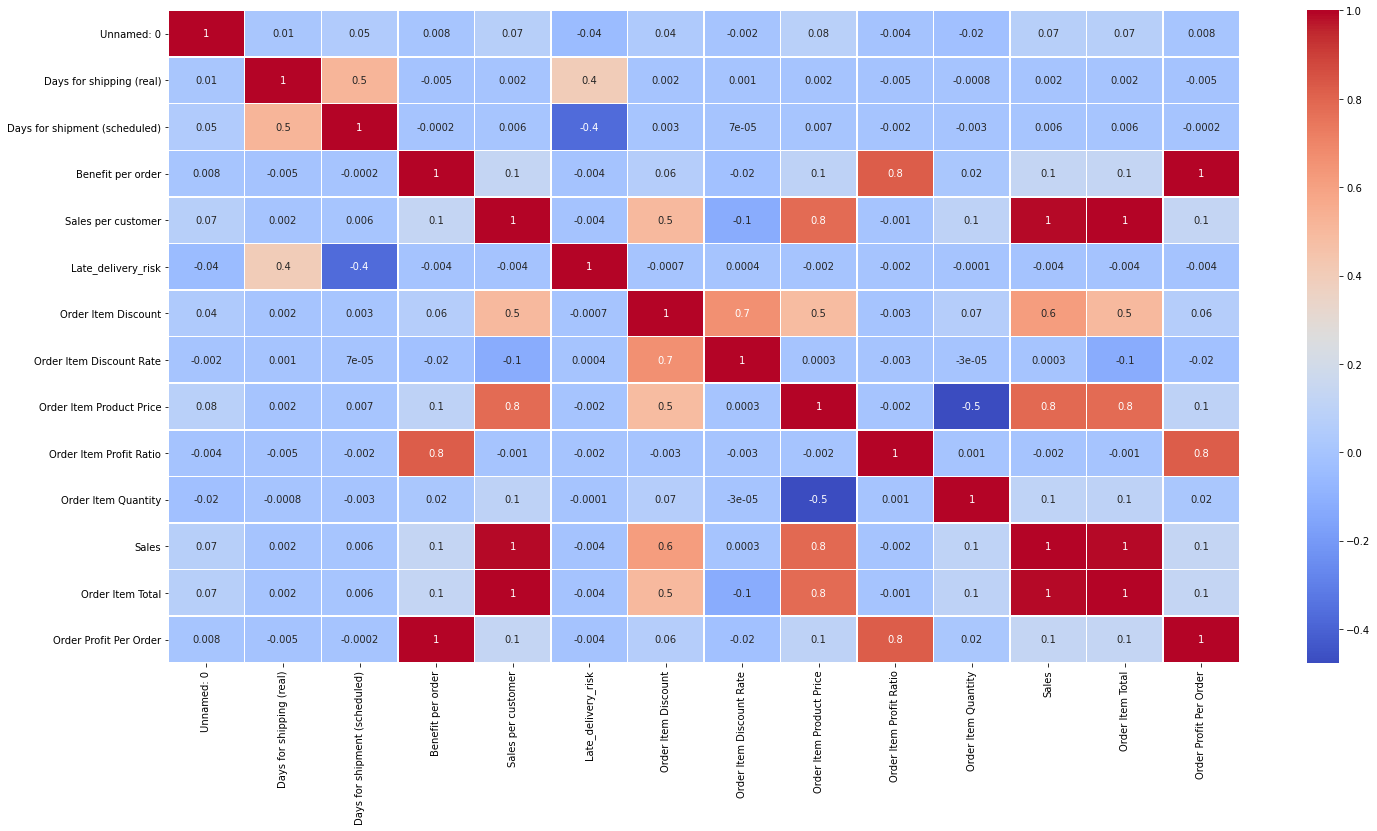

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(24,12))         # figsize
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix

In [ ]:
data=data.drop(['Unnamed: 0','Order Item Discount Rate'],axis=1)
#execute only once

In [ ]:
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Market,Order City,Order Country,order date (DateOrders),Order Item Discount,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Name,Shipping Mode,Customer Name
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,Fitness,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,13.110000,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,Smart watch,Standard Class,CallyHolloway
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,Fitness,Pacific Asia,Bikaner,India,1/13/2018 12:27,16.389999,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,RajastÃ¡n,PENDING,Smart watch,Standard Class,IreneLuna
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,Consumer,CA,Fitness,Pacific Asia,Bikaner,India,1/13/2018 12:06,18.030001,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,RajastÃ¡n,CLOSED,Smart watch,Standard Class,GillianMaldonado
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,Home Office,CA,Fitness,Pacific Asia,Townsville,Australia,1/13/2018 11:45,22.940001,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,Smart watch,Standard Class,TanaTate
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,Fitness,Pacific Asia,Townsville,Australia,1/13/2018 11:24,29.500000,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,Smart watch,Standard Class,OrliHendricks


**Pyspark Classification**

In [ ]:
#!pip install pyspark
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.appName("decision tree for late shipping").getOrCreate()

print(spark.sparkContext.appName)

decision tree for late shipping


In [ ]:
ship_df = spark.createDataFrame(data) 
ship_df.show(10)

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+------------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk| Category Name|Customer City|Customer Country|Customer Segment|Customer State|Department Name|      Market|Order City|Order Country|order date (DateOrders)|Order Item Discount|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity| Sales|  Order Item Total|Order Profit Per Order|  Order Region|    Order State|   Order S

In [ ]:
ship_df.dtypes

[('Type', 'string'),
 ('Days for shipping (real)', 'bigint'),
 ('Days for shipment (scheduled)', 'bigint'),
 ('Benefit per order', 'double'),
 ('Sales per customer', 'double'),
 ('Delivery Status', 'string'),
 ('Late_delivery_risk', 'bigint'),
 ('Category Name', 'string'),
 ('Customer City', 'string'),
 ('Customer Country', 'string'),
 ('Customer Segment', 'string'),
 ('Customer State', 'string'),
 ('Department Name', 'string'),
 ('Market', 'string'),
 ('Order City', 'string'),
 ('Order Country', 'string'),
 ('order date (DateOrders)', 'string'),
 ('Order Item Discount', 'double'),
 ('Order Item Product Price', 'double'),
 ('Order Item Profit Ratio', 'double'),
 ('Order Item Quantity', 'bigint'),
 ('Sales', 'double'),
 ('Order Item Total', 'double'),
 ('Order Profit Per Order', 'double'),
 ('Order Region', 'string'),
 ('Order State', 'string'),
 ('Order Status', 'string'),
 ('Product Name', 'string'),
 ('Shipping Mode', 'string'),
 ('Customer Name', 'string')]

**Changing Datatypes**

In [ ]:
#string column labels to double
indexers = [StringIndexer(inputCol="Delivery Status", outputCol = "Status"), 
           StringIndexer(inputCol="Type", outputCol = "type"), 
           StringIndexer(inputCol="Category Name", outputCol = "Category_Name"), 
           StringIndexer(inputCol="Customer Segment", outputCol = "Customer_Segment"), 
           StringIndexer(inputCol="Department Name", outputCol = "Department_Name"),
           StringIndexer(inputCol="Late_delivery_risk", outputCol = "Risk",stringOrderType='frequencyAsc'),
           StringIndexer(inputCol="Order Region", outputCol = "region"),
           StringIndexer(inputCol="Market", outputCol = "market")]

pipeline = Pipeline(stages=indexers)
indexed_ship_df = pipeline.fit(ship_df).transform(ship_df)     #Fits a model to the input dataset.

indexed_ship_df.show(10,False)  #We have given False for turn off default truncation

+----+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+------------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+------+-------------+----------------+---------------+----+------+
|type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status  |Late_delivery_risk|Category Name |Customer City|Customer Country|Customer Segment|Customer State|Department Name|market|Order City|Order Country|order date (DateOrders)|Order Item Discount|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity|Sales |Order Item Total  |Order Profit Per O

**Create feature column**

In [ ]:
#only real shipment do not put Risk
vectorAssembler = VectorAssembler(inputCols = ['type','Days for shipping (real)','region',
                                               'Customer_Segment','Department_Name'],outputCol = "features")
vindexed_ship_df = vectorAssembler.transform(indexed_ship_df)
vindexed_ship_df.show(5, False)

+----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+--------------+-------------+----------------+----------------+--------------+---------------+------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+-----------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+------+-------------+----------------+---------------+----+------+---------------------+
|type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status |Late_delivery_risk|Category Name |Customer City|Customer Country|Customer Segment|Customer State|Department Name|market|Order City|Order Country|order date (DateOrders)|Order Item Discount|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity|Sales |Order Item Total |

In [ ]:
#do not drop risk
vindexed_ship_df=vindexed_ship_df.drop('type','Days for shipping (real)','Days for shipment (scheduled)','Sales per customer','Benefit per order','Status',
                                            'ship_mode','Customer Segment','Customer City','Delivery Status','Category Name','Category_Name','Customer_Segment','Department_Name','market')

vindexed_ship_df.show(5, False)

+------------------+----------------+--------------+---------------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+-----------------+----------------------+--------------+---------------+---------------+------------+--------------+----------------+----+------+---------------------+
|Late_delivery_risk|Customer Country|Customer State|Department Name|Order City|Order Country|order date (DateOrders)|Order Item Discount|Order Item Product Price|Order Item Profit Ratio|Order Item Quantity|Sales |Order Item Total |Order Profit Per Order|Order Region  |Order State    |Order Status   |Product Name|Shipping Mode |Customer Name   |Risk|region|features             |
+------------------+----------------+--------------+---------------+----------+-------------+-----------------------+-------------------+------------------------+-----------------------+-------------------+------+-----------------+-------

In [ ]:
#do not drop risk
ml_dataset=vindexed_ship_df.drop('Customer Country','Customer State','Department Name','Order City','region',
                                       'Order Country','order date (DateOrders)','Order Item Discount','Late_delivery_risk',
                                       'Order Item Product Price','Order Item Profit Ratio','Order Item Quantity',
                                       'Sales','Order Item Total','Order Profit Per Order','Order Region',
                                       'Order State','Order Status','Product Name','Shipping Mode','Customer Name')

ml_dataset.show(10,False)

+----+----------------------+
|Risk|features              |
+----+----------------------+
|0.0 |[0.0,3.0,5.0,0.0,5.0] |
|1.0 |[1.0,5.0,9.0,0.0,5.0] |
|0.0 |[3.0,4.0,9.0,0.0,5.0] |
|0.0 |[0.0,3.0,3.0,2.0,5.0] |
|0.0 |[2.0,2.0,3.0,1.0,5.0] |
|0.0 |[1.0,6.0,3.0,0.0,5.0] |
|1.0 |[0.0,2.0,10.0,2.0,5.0]|
|1.0 |[1.0,2.0,10.0,1.0,5.0]|
|1.0 |[3.0,3.0,10.0,1.0,5.0]|
|1.0 |[3.0,2.0,10.0,1.0,5.0]|
+----+----------------------+
only showing top 10 rows



**Classification Model**

In [ ]:
#index the label for class column but run only once
#lable_indexer = StringIndexer(inputCol='Days for shipping (real)', outputCol='day',stringOrderType="alphabetAsc") #assigns number to label
#ml_dataset = lable_indexer.fit(ml_dataset).transform(ml_dataset)
#ml_dataset.show(10,False)

In [ ]:
#Split the data into training and test sets (20% held out for testing)

(trainingData, testData) = ml_dataset.randomSplit([0.8, 0.2],42)

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="Risk", featuresCol="features",impurity='gini')

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[ml_dataset, dt])

# Train model.  This also runs the indexers.
model = dt.fit(trainingData)

# Make predictions.
prediction = model.transform(testData)

# Select example rows to display.
prediction.show(10,False)
#df.printSchema()

+----+-------------+-------------+-----------+----------+
|Risk|features     |rawPrediction|probability|prediction|
+----+-------------+-------------+-----------+----------+
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[],[])    |[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[0],[1.0])|[4064.0,0.0] |[1.0,0.0]  |0.0       |
|0.0 |(5,[0],[1.0])|[4064.0,0.0] |[1.0,0.0]  |0.0       |
+----+-------------+-------------+-----------+----------+
only showing top 10 rows



**Model Evaluation**

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Risk", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
#print("Accuracy : " , accuracy)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.24091 


In [ ]:
print('Learned classification tree model:')
print(model.toDebugString)

Learned classification tree model:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e1a86be5445d, depth=4, numNodes=9, numClasses=2, numFeatures=5
  If (feature 1 <= 4.5)
   If (feature 1 <= 2.5)
    If (feature 1 <= 0.5)
     Predict: 0.0
    Else (feature 1 > 0.5)
     If (feature 1 <= 1.5)
      Predict: 1.0
     Else (feature 1 > 1.5)
      Predict: 0.0
   Else (feature 1 > 2.5)
    Predict: 0.0
  Else (feature 1 > 4.5)
   Predict: 1.0

